## Step1: Data Exploration
**Objective**:
To explore and analyze the Playing Cards dataset in order to understand its structure and characteristics before the modeling phase.

**Main Goals**:
- Perform an initial assessment of data quality and completeness.
- Identify attribute types and their distributions.
- Detect missing, inconsistent, or anomalous values.
- Visualize data through appropriate plots to support interpretation.

**Methods and Tools**:
- Statistical summaries using descriptive measures (mean, median, standard deviation, etc.).
- Visual exploration with histograms, boxplots, and scatter plots.
- Correlation analysis between features.

**Outcome**:
- Clear overview of the dataset and its key properties.
- Identification of relevant features and potential preprocessing needs.
- Foundation for subsequent steps in the Intelligent System design process, following the KDD methodology (selection, preprocessing, modeling, and evaluation).


### 0) Setup and Utility Functions
In order to work with the dataset, we define some utility functions to handle YOLO format annotations and load dataset splits and class names from a possible `data.yaml` file.

In [8]:
import pandas as pd

import os, json, math, glob, yaml, random, statistics
from pathlib import Path
from collections import Counter, defaultdict
import numpy as np
import seaborn as sns
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

dataset_paths = [
    "./datasets/Playing-Cards-Images-Object-Detection-Dataset/voc_all_converted.csv",
    "./datasets/Playing-Cards-Object-Detection-Dataset/yolo_all_converted.csv",
    "./datasets/Playing-Cards-Labelized-Dataset/labelized_all_converted.csv",
    "./datasets/The-Complete-Playing-Card-Dataset/complete_converted.csv"
]

df = pd.read_csv(dataset_paths[1])
print(df.head())

# Missing labels analysis
missing = df['class_name'].isna().mean()*100
print(f"\n% images without labels: {missing:.2f}%")

                                               image  class_id class_name  \
0  datasets/Playing-Cards-Object-Detection-Datase...        51         Qs   
1  datasets/Playing-Cards-Object-Detection-Datase...        37         Ad   
2  datasets/Playing-Cards-Object-Detection-Datase...        37         Ad   
3  datasets/Playing-Cards-Object-Detection-Datase...        17         5d   
4  datasets/Playing-Cards-Object-Detection-Datase...        24         7c   

   bbox_x_center  bbox_y_center  bbox_width  bbox_height  image_width  \
0       0.460337       0.693510    0.064904     0.042067        416.0   
1       0.644231       0.501202    0.063702     0.088942        416.0   
2       0.614183       0.074519    0.064904     0.088942        416.0   
3       0.480769       0.793269    0.063702     0.055288        416.0   
4       0.445913       0.737981    0.066106     0.052885        416.0   

   image_height  
0         416.0  
1         416.0  
2         416.0  
3         416.0  
4       

### 3) Dimensioni immagini

       image_width  image_height   aspect
count      75750.0       75750.0  75750.0
mean         416.0         416.0      1.0
std            0.0           0.0      0.0
min          416.0         416.0      1.0
25%          416.0         416.0      1.0
50%          416.0         416.0      1.0
75%          416.0         416.0      1.0
max          416.0         416.0      1.0


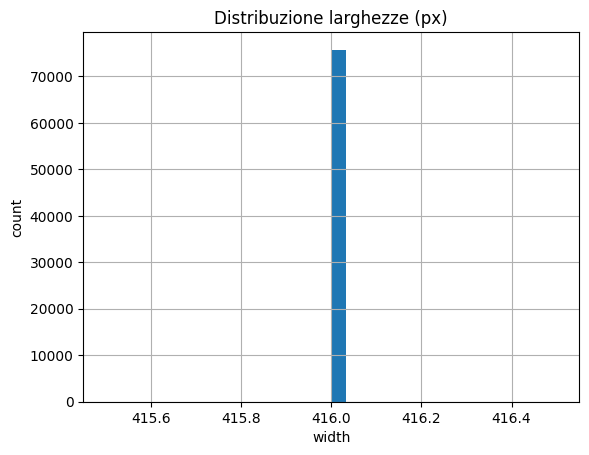

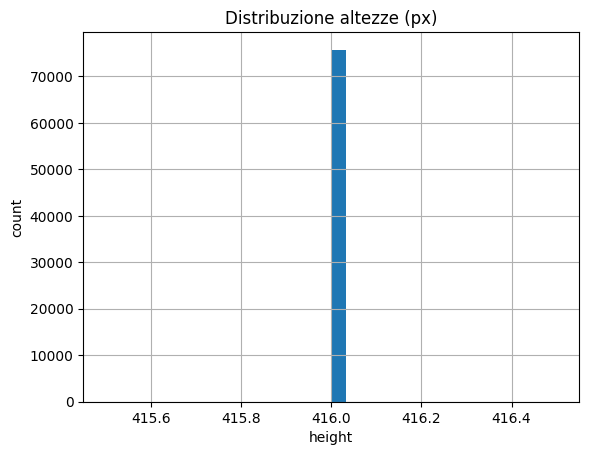

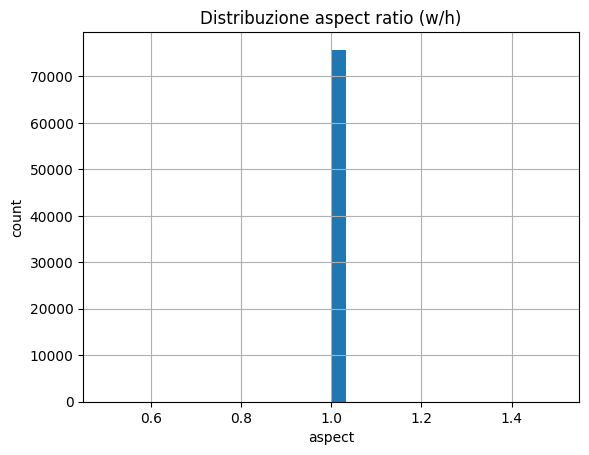

Outliers dimensionali: 0 immagini

Empty DataFrame
Columns: [image, image_width, image_height]
Index: []


In [10]:
df['aspect'] = df['image_width'] / df['image_height']

print(df[['image_width','image_height','aspect']].describe())

# Istogrammi (uno per volta, niente subplot né colori custom)
plt.figure()
df['image_width'].dropna().hist(bins=30)
plt.title('Distribuzione larghezze (px)')
plt.xlabel('width')
plt.ylabel('count')
plt.show()

plt.figure()
df['image_height'].dropna().hist(bins=30)
plt.title('Distribuzione altezze (px)')
plt.xlabel('height')
plt.ylabel('count')
plt.show()

plt.figure()
df['aspect'].dropna().hist(bins=30)
plt.title('Distribuzione aspect ratio (w/h)')
plt.xlabel('aspect')
plt.ylabel('count')
plt.show()

# check
outliers = df[
    (df['image_width'] > df['image_width'].quantile(0.99)) |
    (df['image_width'] < df['image_width'].quantile(0.01)) |
    (df['image_height'] > df['image_height'].quantile(0.99)) |
    (df['image_height'] < df['image_height'].quantile(0.01))
]

print(f"Outliers dimensionali: {len(outliers)} immagini\n")
print(outliers[['image', 'image_width', 'image_height']])

### 4) Lettura etichette YOLO e statistiche bbox

                                               image  class_id class_name  \
0  datasets/The-Complete-Playing-Card-Dataset/Ima...         0        10c   
1  datasets/The-Complete-Playing-Card-Dataset/Ima...         0        10c   
2  datasets/The-Complete-Playing-Card-Dataset/Ima...         0        10c   
3  datasets/The-Complete-Playing-Card-Dataset/Ima...         0        10c   
4  datasets/The-Complete-Playing-Card-Dataset/Ima...         0        10c   

         xc        yc         w         h      area    aspect  img_w  img_h  
0  0.325087  0.665365  0.083767  0.039641  0.003321  2.113140   4608   3456  
1  0.326280  0.623698  0.073134  0.069734  0.005100  1.048757   4608   3456  
2  0.559462  0.498264  0.092448  0.063079  0.005832  1.465591   4608   3456  
3  0.513997  0.449508  0.051432  0.068576  0.003527  0.750000   4608   3456  
4  0.307834  0.513889  0.055339  0.079282  0.004387  0.698002   4608   3456  

Totale bbox: 2707
Bbox con normalizzazione fuori [0,1]: 0
Bbox con a

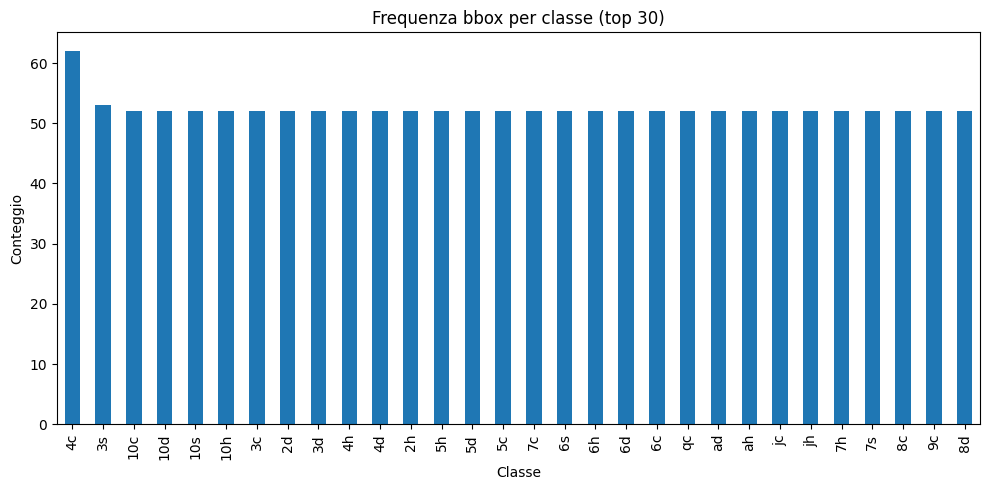

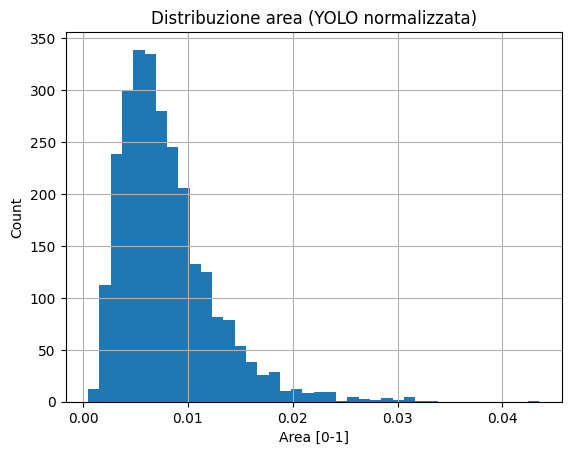

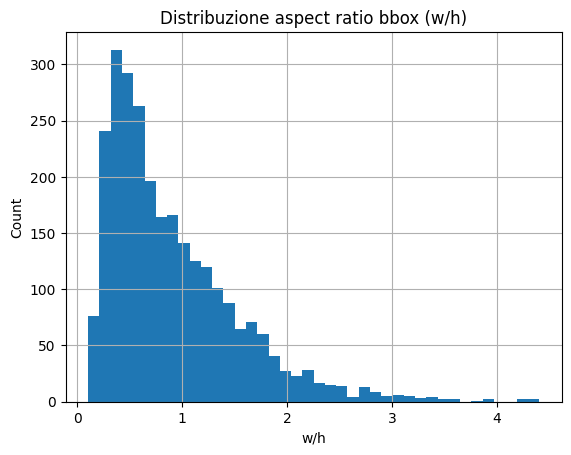

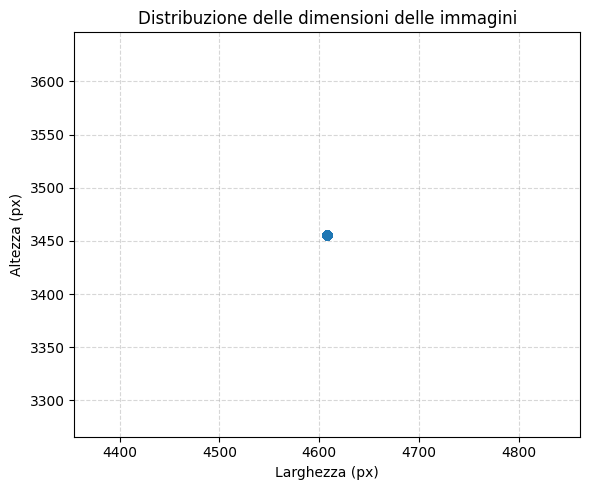

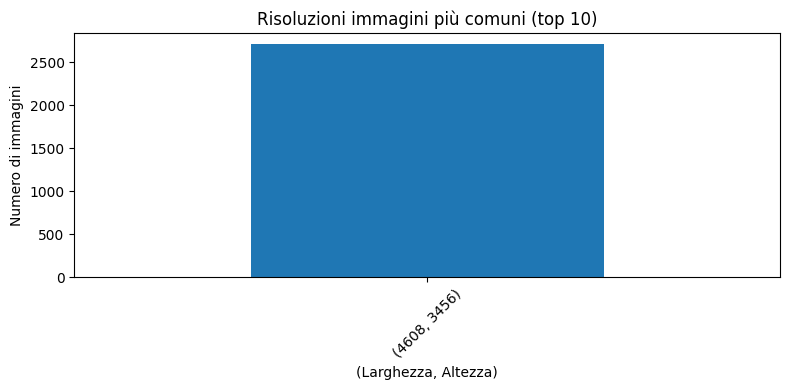

In [3]:


# --- Inizializzazione contatori ---
bad_norm = 0
zero_area = 0

label_rows = []

# --- Iterazione su tutte le righe ---
for idx, r in df.dropna(subset=['class_id']).iterrows():
    W, H = int(r['image_width']), int(r['image_height'])
    cls = int(r['class_id'])
    xc, yc, w, h = r['bbox_x_center'], r['bbox_y_center'], r['bbox_width'], r['bbox_height']

    # Controlli di validità
    if not (0 <= xc <= 1 and 0 <= yc <= 1 and 0 <= w <= 1 and 0 <= h <= 1):
        bad_norm += 1
    if w <= 0 or h <= 0:
        zero_area += 1

    # Calcoli derivati
    area = w * h
    aspect = (w / h) if h > 0 else None

    label_rows.append({
        "image": r['image'],
        "class_id": cls,
        "class_name": r.get('class_name', f'class_{cls}'),
        "xc": xc, "yc": yc, "w": w, "h": h,
        "area": area, "aspect": aspect,
        "img_w": W, "img_h": H
    })

# --- Creazione DataFrame ---
labels_df = pd.DataFrame(label_rows)

# --- Report generale ---
print(labels_df.head())
print(f"\nTotale bbox: {len(labels_df)}")
print(f"Bbox con normalizzazione fuori [0,1]: {bad_norm}")
print(f"Bbox con area nulla (w==0 o h==0): {zero_area}")

# --- Distribuzione classi ---
print("\nDistribuzione classi (prime 20):\n", labels_df['class_name'].value_counts().head(20))

# --- Grafico: frequenza per classe ---
plt.figure(figsize=(10,5))
labels_df['class_name'].value_counts().head(30).plot(kind='bar')
plt.title('Frequenza bbox per classe (top 30)')
plt.xlabel('Classe')
plt.ylabel('Conteggio')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# --- Grafico: distribuzione area bbox ---
plt.figure()
labels_df['area'].dropna().hist(bins=40)
plt.title('Distribuzione area (YOLO normalizzata)')
plt.xlabel('Area [0-1]')
plt.ylabel('Count')
plt.show()

# --- Grafico: distribuzione aspect ratio ---
plt.figure()
labels_df['aspect'].dropna().hist(bins=40)
plt.title('Distribuzione aspect ratio bbox (w/h)')
plt.xlabel('w/h')
plt.ylabel('Count')
plt.show()


# --- Distribuzione dimensioni delle immagini ---
plt.figure(figsize=(6,5))
plt.scatter(labels_df['img_w'], labels_df['img_h'], alpha=0.5)
plt.title("Distribuzione delle dimensioni delle immagini")
plt.xlabel("Larghezza (px)")
plt.ylabel("Altezza (px)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- Istogramma risoluzioni più comuni ---
plt.figure(figsize=(8,4))
res_counts = labels_df.groupby(['img_w', 'img_h']).size().sort_values(ascending=False).head(10)
res_counts.plot(kind='bar')
plt.title("Risoluzioni immagini più comuni (top 10)")
plt.xlabel("(Larghezza, Altezza)")
plt.ylabel("Numero di immagini")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 5) Visualizzazione esempi con bounding box

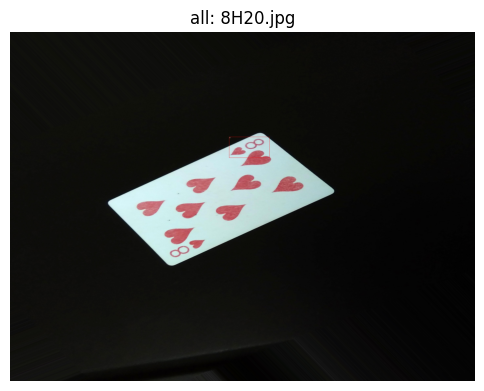

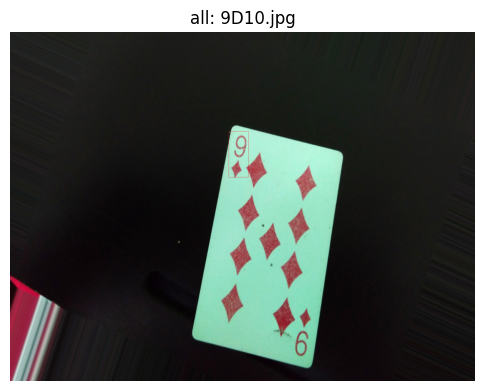

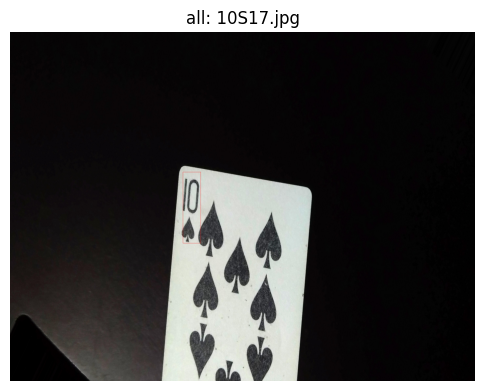

In [4]:

def draw_yolo_boxes_from_df(df, image_path, class_names=None, max_boxes=50):
    """
    Disegna le bounding box YOLO direttamente dai dati del DataFrame.
    """
    # Seleziona tutte le box relative a quell'immagine
    boxes = df[df['image'] == image_path].head(max_boxes)
    if boxes.empty:
        return None

    im = Image.open(image_path).convert("RGB")
    W, H = im.size
    draw = ImageDraw.Draw(im)

    for _, r in boxes.iterrows():
        xc, yc, w, h = r['bbox_x_center'], r['bbox_y_center'], r['bbox_width'], r['bbox_height']

        # Conversione YOLO → coordinate assolute (x1,y1,x2,y2)
        x1 = (xc - w/2) * W
        y1 = (yc - h/2) * H
        x2 = (xc + w/2) * W
        y2 = (yc + h/2) * H

        # Disegna rettangolo e testo
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        label = str(r['class_id'])
        if class_names is not None:
            if isinstance(class_names, list) and int(r['class_id']) < len(class_names):
                label = class_names[int(r['class_id'])]
            elif 'class_name' in r:
                label = r['class_name']
        draw.text((x1 + 2, y1 + 2), label, fill="white")

    return im


# --- Esempio: mostra 3 immagini casuali dal dataset ---
random.seed(0)

# Se vuoi filtrare per split, controlla che la colonna 'split' esista:
splits = df['split'].unique() if 'split' in df.columns else ['all']

for split in splits:
    subset = df[df['split'] == split] if split != 'all' else df
    unique_images = subset['image'].unique()
    sample_images = random.sample(list(unique_images), min(3, len(unique_images)))

    for img_path in sample_images:
        im = draw_yolo_boxes_from_df(df, img_path, class_names=df['class_name'].unique().tolist())
        if im is not None:
            plt.figure(figsize=(6, 6))
            plt.imshow(im)
            plt.axis('off')
            title = f"{split}: {os.path.basename(img_path)}"
            plt.title(title)
            plt.show()

### 6) Statistiche per immagine

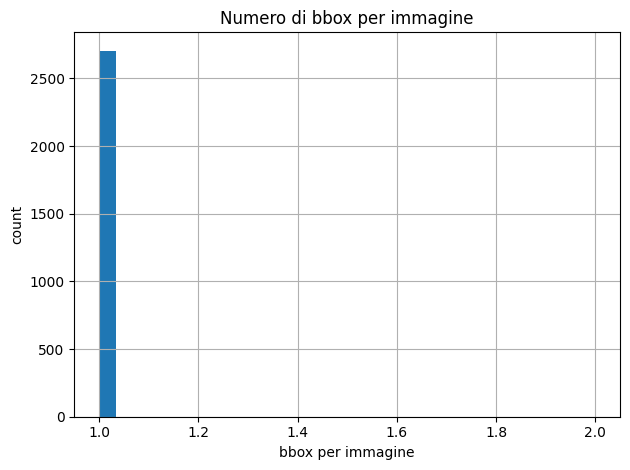

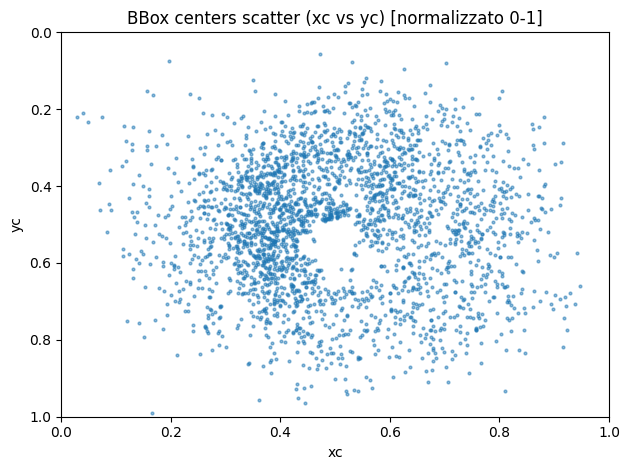

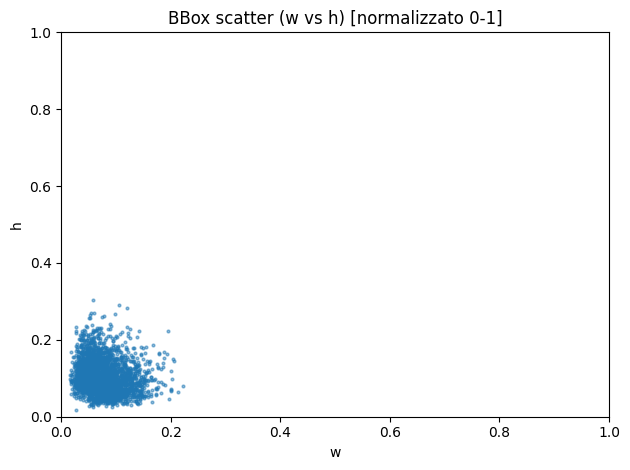

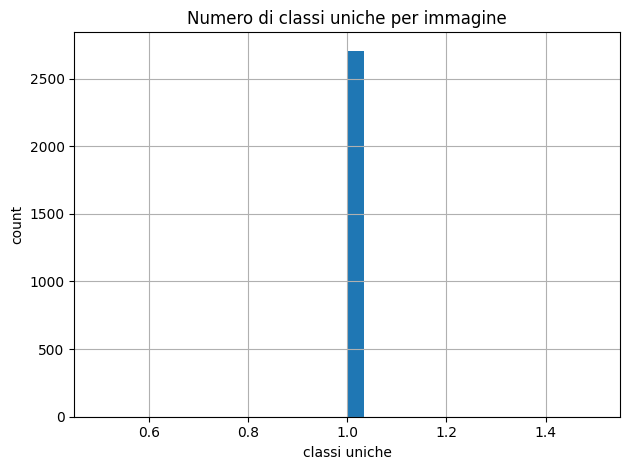

In [5]:

# --- Numero di bbox per immagine ---
bbox_per_image = labels_df.groupby('image').size()

plt.figure()
bbox_per_image.hist(bins=30)
plt.title('Numero di bbox per immagine')
plt.xlabel('bbox per immagine')
plt.ylabel('count')
plt.tight_layout()
plt.show()

# --- Scatter dei centri bbox normalizzati (xc, yc) ---
if len(labels_df) > 0:
    n = min(10000, len(labels_df))
    sample_centers = labels_df.sample(n, random_state=0)[["xc", "yc"]].dropna()
    plt.figure()
    plt.scatter(sample_centers["xc"], sample_centers["yc"], s=4, alpha=0.5)
    plt.title("BBox centers scatter (xc vs yc) [normalizzato 0-1]")
    plt.xlabel("xc")
    plt.ylabel("yc")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().invert_yaxis()  # origine in alto come nelle immagini
    plt.tight_layout()
    plt.show()
else:
    print("labels_df è vuoto: nessuna bbox da visualizzare.")

# --- Scatter (w vs h) YOLO normalizzato ---
if len(labels_df) > 0:
    bb = labels_df[["w", "h"]].dropna()
    n = min(20000, len(bb))
    bb = bb.sample(n, random_state=0)
    plt.figure()
    plt.scatter(bb["w"], bb["h"], s=4, alpha=0.5)
    plt.title("BBox scatter (w vs h) [normalizzato 0-1]")
    plt.xlabel("w")
    plt.ylabel("h")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
else:
    print("labels_df è vuoto: nessuna bbox da visualizzare.")

# --- Numero di classi uniche per immagine ---
classes_per_image = labels_df.groupby('image')['class_id'].nunique()

plt.figure()
classes_per_image.hist(bins=30)
plt.title('Numero di classi uniche per immagine')
plt.xlabel('classi uniche')
plt.ylabel('count')
plt.tight_layout()
plt.show()


### 7) Sanity check su etichette

In [6]:
# --- Bounding box fuori dai limiti normalizzati ---
out_of_bounds = labels_df.query(
    'xc < 0 or xc > 1 or yc < 0 or yc > 1 or w < 0 or w > 1 or h < 0 or h > 1'
).shape[0]
print("Bbox con valori fuori [0,1]:", out_of_bounds)

# --- Bounding box troppo piccole o troppo grandi ---
too_small = labels_df.query('w * h < 1e-5').shape[0]
too_big = labels_df.query('w > 0.9 or h > 0.9').shape[0]
print("Bbox troppo piccole:", too_small)
print("Bbox molto grandi (w > 0.9 o h > 0.9):", too_big)

# --- Immagini senza alcuna label ---
# (cioè presenti in df ma non in labels_df)
all_images = set(df['image'])
labeled_images = set(labels_df['image'])
missing_images = all_images - labeled_images
missing_pct = (len(missing_images) / len(all_images) * 100) if len(all_images) else 0
print(f"Immagini senza label: {missing_pct:.2f}% ({len(missing_images)} su {len(all_images)})")


Bbox con valori fuori [0,1]: 0
Bbox troppo piccole: 0
Bbox molto grandi (w > 0.9 o h > 0.9): 0
Immagini senza label: 0.00% (0 su 2706)


### 8) Riassunto e takeaway

- **Distribuzione classi:** verificare sbilanciamenti e, se necessario, pianificare un **weighted sampling** o **data augmentation** mirata.

- **Dimensioni immagini:** uniformare (es. resize) se molto variabili; considerare il mantenimento del ratio.

- **Bbox:** controllare outliers (aree troppo piccole/grandi) che possono influenzare il training.

- **Qualità etichette:** correggere eventuali valori fuori range o bbox nulle.

- **Split:** assicurarsi che **train/val/test** siano coerenti e non sovrapposti.



> Questi insight guidano **Step 3 (preprocessing)** e la scelta del modello (es. YOLOv5/8) per **Step 4 (processing)**.
